In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

from vae_interp.dataset import load_nouns_dataset
import matplotlib.pyplot as plt
from vae_interp.sae import SAE
from vae_interp.vae import VAE
import torch

/home/ubuntu/.cache/pypoetry/virtualenvs/nouns-mech-interp-YeAXWnnL-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = load_nouns_dataset(image_size=64, normalize=True)

In [7]:
vae = VAE.load_from_dir("../weights/vae")
sae = SAE.load_from_checkpoint("../weights/sae/config.json", "../weights/sae/sae.pth")

vae.eval()
sae.eval()

SAE()

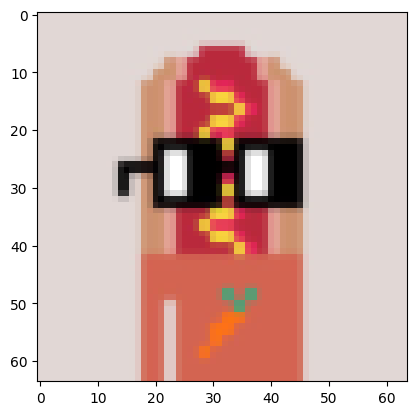

In [37]:
image_id = 0
image = dataset[image_id]

plt.imshow((image.permute(1, 2, 0) + 1) * 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012595475..1.0].


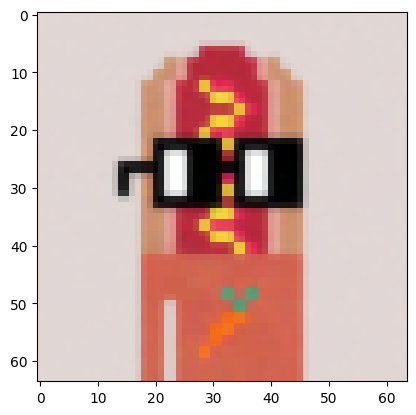

In [38]:
with torch.no_grad():
    recon = vae(image.unsqueeze(0))["recon"].squeeze(0)
    recon = torch.clamp((recon + 1) * 0.5, -1, 1)

plt.imshow(recon.permute(1, 2, 0))

In [39]:
mu, _ = vae.encode(image.unsqueeze(0))
latent = mu.view(1, -1)
features = sae.encode(latent).squeeze(0)
feature_indices = torch.where(features != 0)
activations = features[feature_indices]

features_list = []

for i in range(activations.shape[0]):
    features_list.append({
        "feature_id": int(feature_indices[0][i].item()),
        "activation": activations[i].item()
    })

features_list = sorted(features_list, key=lambda x: x["activation"], reverse=True)
features_list

[{'feature_id': 197, 'activation': 2.955507278442383},
 {'feature_id': 685, 'activation': 0.12281584739685059},
 {'feature_id': 481, 'activation': 0.08602398633956909},
 {'feature_id': 896, 'activation': 0.08587047457695007},
 {'feature_id': 1000, 'activation': 0.0675773024559021},
 {'feature_id': 687, 'activation': 0.03907740116119385},
 {'feature_id': 112, 'activation': 0.03437304496765137}]

In [ ]:
image -> vae.encode -> latent -> sae.encode -> features -> sae.decode -> recon_latent -> vae.decode -> recon_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.017725766..1.0].


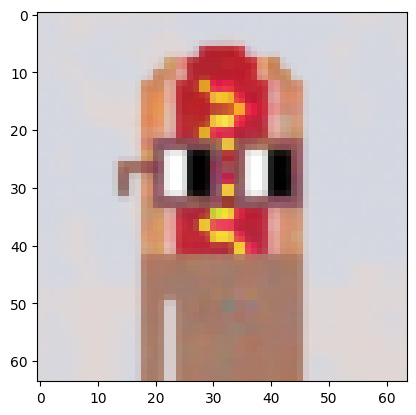

In [41]:
with torch.no_grad():
    recon_latent = sae.decode(features.unsqueeze(0)).view(1, 4, 4, 4)
    recon_image = vae.decode(recon_latent).squeeze(0)
    recon_image = torch.clamp((recon_image + 1) * 0.5, -1, 1)

plt.imshow(recon_image.permute(1, 2, 0))